<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Spatial_interpolation/data_processing_spatial_interplolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Spatial Interpolation

Spatial interpolation is a geostatistical technique used in geographic information systems (GIS), remote sensing, and various fields of earth and environmental sciences to estimate values of a variable at unmeasured or irregularly spaced locations within a defined geographic area. It is particularly useful when you have data points at specific locations but need to make predictions or create continuous surfaces for areas between those points.

The primary goal of spatial interpolation is to create a continuous representation of a variable across space, allowing us to visualize and analyze data more effectively.

## Data Preparation for Spatial Interpolation

In this section, we will learn how to integrate different spatial data and create a data frame for spatial interpolation.

This exercise consists of six significant steps:

1. Create a Spatial Point Data Frame

2. Extract Environmental Covariates to SPDF

3. Create a Prediction Grid

4. Data split

### Install rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.1
Uninstalling rpy2-3.5.1:
  Successfully uninstalled rpy2-3.5.1
  Using cached rpy2-3.5.1-cp310-cp310-linux_x86_64.whl


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Check and Instal R packages

In [ ]:
%%R
pkg <- c('tidyverse', 'raster', 'rgdal','terra','tidyterra', 'maptools', 'sf', 'classInt',
         'RColorBrewer', 'tmap','tmaptools', 'gridExtra', 'devtools', 'data.table', 'gstat','Hmisc','corrplot', 'ggmap','plyr')
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

### Load R packages

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
library (terra)
library(tidymodels)
library(sf)
library(raster)
library(RColorBrewer)
library(RStoolbox)
library(gridExtra)
library(latticeExtra)
library(data.table)
library(gstat)
library(Hmisc)
library(corrplot)
library(classInt)
library(plyr)

### Data

We will use following spatial data to create the data frame. The data could be download from [here](https://github.com/zia207/r-colab/tree/main/Data/Spatial_interpolation).

* Soil sampling locations (GP_GPS.CSV): This file contains coordinates of 473 soil sampling sites in Colorado, Kansas, New Mexico, and Wyoming. The soil samples were collected by United States Geological Survey (USGS) throughout the A horizon with sampling densities of 1 sample per ~1600 km2.

* Soil organic carbon (SOC) (GP_SOC_data.csv): SOC concentration of these 473 sites. The concentration of SOC was predicted by means of mid-infrared (MIR) spectroscopy and partial least squares regression (PLSR) analysis described previously [Janik et al., 2007; Ahmed et al., 2017].

* Raster data: DEM (ELEV), slope, aspect, topographic position index (TPI), mean annual air temperature (MAT), mean annual precipitation (MAP), soil texture (Silt+Clay), Fire Regime Groups(FRG), Normalized Difference Vegetation Index (NDVI), and land cover (NLCD) and soil erodibility factor (K_factor). This data has downloaded from here and detail description of the data can be found in Assessing soil carbon vulnerability in the Western USA by geospatial modeling of pyrogenic and particulate carbon stocks. For training purpose, all raster was re-sampled to 10 km x 10 km grid size.

In [5]:
%%R
# soil id file
ID<-fread('/content/drive/MyDrive/Data/Spatial_Interpolatiom/GP_ID.csv')
# soil sampling location
gps<-fread('/content/drive/MyDrive/Data/Spatial_Interpolatiom/GP_GPS.csv')
# soil data files
data<-fread('/content/drive/MyDrive/Data/Spatial_Interpolatiom/GP_SOC_data.csv')

### Merge data

In [6]:
%%R
df<-inner_join(ID, gps) %>%
    inner_join(data)
head(df)

Joining with `by = join_by(ID)`
Joining with `by = join_by(ID)`
   ID STATE_ID   STATE  FIPS         COUNTY Longitude Latitude    SOC
1:  1       56 Wyoming 56041   Uinta County -111.0119 41.05630 15.763
2:  2       56 Wyoming 56023 Lincoln County -110.9830 42.88350 15.883
3:  3       56 Wyoming 56039   Teton County -110.8065 44.53497 18.142
4:  4       56 Wyoming 56039   Teton County -110.7344 44.43289 10.745
5:  5       56 Wyoming 56029    Park County -110.7308 44.80635 10.479
6:  6       56 Wyoming 56039   Teton County -110.6619 44.09124 16.987


### Create a Spatial Point Dataframe

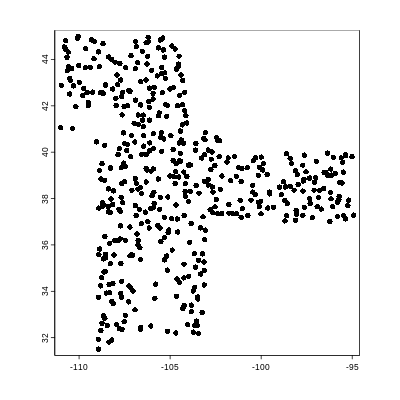

In [65]:
%%R -w 400 -h 400 -u px
sp <- vect(df, geom=c("Longitude", "Latitude"))
plot(sp)

### Define projection
We will define current CRS (WGS 84) before re-project it to **Albers Equal Area Conic NAD1983"

In [66]:
%%R
crs(sp)<-"+proj=longlat +ellps=WGS84"

In [157]:
%%R
state<-vect("/content/drive/MyDrive/Data/Spatial_Interpolatiom/GP_STATE.shp")
albers=crs(state)

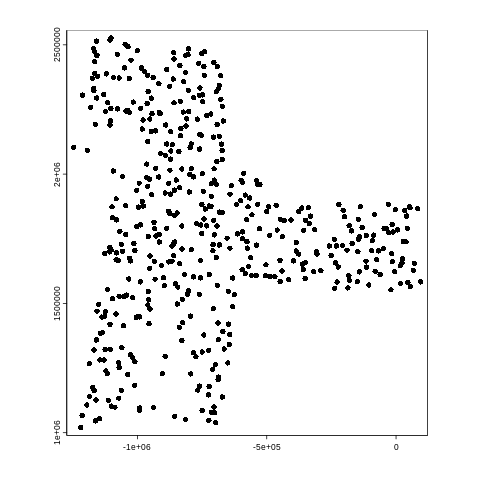

In [70]:
%%R
# Albers Equal Area Conic NAD1983
sp.proj<-project(sp, albers)
plot(sp.proj)

### Extract Environmental Covariates to point dataframe

Now, we will extract raster values to SPDF data frame the Characterize the sampling locations with a comprehensive set of environmental data. First, you have to create a list of raster and then use rast() function to read them.

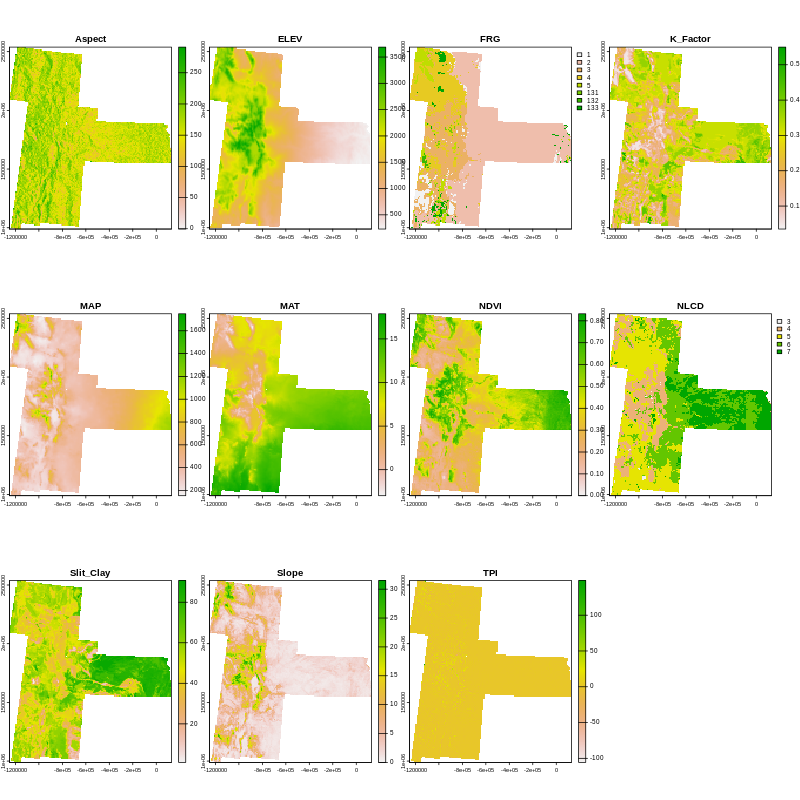

In [71]:
%%R -w 800 -h 800 -u px
datafolder= "/content/drive/MyDrive/Data/Spatial_Interpolatiom/RASTER"
glist <- list.files(datafolder, pattern='.tif$',full.names=T)
s<- rast(glist)
s<-project(s, albers)
plot(s)

We will use extract() function from raster package, but extract() will be show some error since it is conflicting with another package, so we use raster::extract function.

In [144]:
%%R
point.mf<-as.data.frame(sp.proj)
head(point.df)
xy<-geom(sp.proj)[,3:4]
point.df<-cbind(point.mf, xy)
head(point.df)

  ID STATE_ID   STATE  FIPS         COUNTY    SOC        x       y
1  1       56 Wyoming 56041   Uinta County 15.763 -1246454 2103948
2  2       56 Wyoming 56023 Lincoln County 15.883 -1211985 2305426
3  3       56 Wyoming 56039   Teton County 18.142 -1169233 2485215
4  4       56 Wyoming 56039   Teton County 10.745 -1165344 2473095
5  5       56 Wyoming 56029    Park County 10.479 -1158637 2514145
6  6       56 Wyoming 56039   Teton County 16.987 -1165502 2434580


In [146]:
%%R
vals<-terra::extract(s,
              sp.proj,
               method="simple")
point.vals<-cbind(point.df,vals)
head(point.vals)

  ID STATE_ID   STATE  FIPS         COUNTY    SOC        x       y ID   Aspect
1  1       56 Wyoming 56041   Uinta County 15.763 -1246454 2103948  1 159.1877
2  2       56 Wyoming 56023 Lincoln County 15.883 -1211985 2305426  2 156.8786
3  3       56 Wyoming 56039   Teton County 18.142 -1169233 2485215  3 168.6124
4  4       56 Wyoming 56039   Teton County 10.745 -1165344 2473095  4 198.3536
5  5       56 Wyoming 56029    Park County 10.479 -1158637 2514145  5 201.3215
6  6       56 Wyoming 56039   Teton County 16.987 -1165502 2434580  6 208.9732
      ELEV FRG  K_Factor       MAP       MAT      NDVI NLCD Slit_Clay    Slope
1 2229.079   4 0.3200000  468.3245 4.5951686 0.4139390    5  64.84270 5.671615
2 1889.400   4 0.2612121  536.3522 3.8599243 0.6939532    5  72.00455 8.913812
3 2423.048   5 0.2162000  859.5509 0.8855000 0.5466033    4  57.18700 4.774805
4 2484.283   5 0.1816667  869.4724 0.4707811 0.6191013    4  54.99166 7.121811
5 2396.195   5 0.1255102  802.9743 0.7588266 0.58447

In [106]:
%%R
point.vals$NLCD<-as.integer(point.vals$NLCD)
point.vals$FRG<-as.integer(point.vals$FRG)
glimpse(point.vals)

Rows: 473
Columns: 20
$ ID        <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1…
$ STATE_ID  <int> 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, …
$ STATE     <chr> "Wyoming", "Wyoming", "Wyoming", "Wyoming", "Wyoming", "Wyom…
$ FIPS      <int> 56041, 56023, 56039, 56039, 56029, 56039, 56039, 56039, 5603…
$ COUNTY    <chr> "Uinta County", "Lincoln County", "Teton County", "Teton Cou…
$ SOC       <dbl> 15.763, 15.883, 18.142, 10.745, 10.479, 16.987, 24.954, 6.28…
$ x         <dbl> -1246454, -1211985, -1169233, -1165344, -1158637, -1165502, …
$ y         <dbl> 2103948, 2305426, 2485215, 2473095, 2514145, 2434580, 237037…
$ ID        <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1…
$ Aspect    <dbl> 159.1877, 156.8786, 168.6124, 198.3536, 201.3215, 208.9732, …
$ ELEV      <dbl> 2229.079, 1889.400, 2423.048, 2484.283, 2396.195, 2360.573, …
$ FRG       <int> 4, 4, 5, 5, 5, 5, 4, 5, 4, 4, 5, 4, 5, 4, 4, 4, 4, 5, 5, 3, …
$ K_Factor  <dbl> 

Since, NLCD and FRG are categorical class raster, you need to add their class description into data frame.

In [107]:
%%R
# Load ID files
NLCD.ID<-fread("/content/drive/MyDrive/Data/Spatial_Interpolatiom/NLCD_ID.csv")
FRG.ID<-fread("/content/drive/MyDrive/Data/Spatial_Interpolatiom/FRG_ID.csv")


In [112]:
%%R
glimpse(FRG.ID)

Rows: 7
Columns: 2
$ FRG_DES <chr> "Barren", "Fire Regime Group I", "Fire Regime Group II", "Fire…
$ FRG     <int> 131, 1, 2, 3, 4, 5, 133


In [118]:
%%R
mf.01 <- merge(point.vals,NLCD.ID,  by="NLCD", type="inner")
mf.02 <- merge(mf.01,FRG.ID,  by="FRG",type="inner")
head(mf.02)
mf.02<- mf.02[, -3]


In [122]:
%%R
# re-arrange the data-frame (use dplyr::select)
mf<-mf.02 %>%
  dplyr::select(ID,STATE_ID,STATE,FIPS, COUNTY,x,y, SOC,
                ELEV,Aspect,Slope, TPI,K_Factor,MAP,MAT,NDVI,
                Slit_Clay,NLCD,FRG,NLCD_DES,FRG_DES)
head(mf)

   ID STATE_ID      STATE  FIPS            COUNTY           x       y    SOC
1 466       20     Kansas 20099    Labette County    45935.33 1580239  7.256
2  55       35 New Mexico 35031   McKinley County -1137299.01 1446994  4.594
3  51        8   Colorado  8033    Dolores County -1106344.79 1716869  5.995
4  67       35 New Mexico 35003     Catron County -1145173.13 1281595 11.220
5 449       20     Kansas 20019 Chautauqua County   -19769.53 1552489  5.388
6  86       35 New Mexico 35003     Catron County -1105687.48 1322861  1.619
       ELEV   Aspect    Slope        TPI  K_Factor       MAP       MAT
1  272.6797 185.0404 1.429968  1.0744587 0.3255294 1099.3408 13.748117
2 2261.7820 222.3785 4.874323 -1.4409482 0.2486000  410.5008  8.162200
3 2404.1121 183.5729 6.680480  7.7656183 0.0590000  568.7746  6.890750
4 2281.4246 173.1285 7.745950 -3.2823703 0.2847475  391.4978  8.533788
5  277.6634 168.1043 2.923675 -0.4226714 0.3750685 1013.7034 14.152466
6 2317.4907 193.8056 2.635038 -1.43

In [124]:
%%R
# Write as CSV file
write.csv(mf,"/content/drive/MyDrive/Data/Spatial_Interpolatiom/GP_all_data.csv", row.names=F)

### Create a Prediction Grid

In [138]:
%%R
# First, we will create an empty point data frame, will ELEV raster
DEM<-rast('/content/drive/MyDrive/Data/Spatial_Interpolatiom/RASTER/ELEV.tif')
grid.xy <-geom(as.points(DEM))
grid.point<-grid.xy[,3:4]
head(grid.point)


            x       y
[1,] -1185285 2533795
[2,] -1175285 2533795
[3,] -1165285 2533795
[4,] -1155285 2533795
[5,] -1145285 2533795
[6,] -1135285 2533795


In [141]:
%%R
grid.sp <- vect(grid.point, crs = albers)

In [149]:
%%R
grid.vals<-terra::extract(s,
              grid.point,
              method='simple')
grid.data<-cbind(grid.point,grid.vals)
grid.na<-na.omit(grid.data)
head(grid.na)

         x       y   Aspect     ELEV FRG  K_Factor       MAP       MAT
1 -1185285 2533795 258.8979 2314.257   5 0.2000000  990.0264 2.1927779
2 -1175285 2533795 217.6896 2482.817   5 0.2000000 1091.2081 1.4273914
3 -1165285 2533795 158.6678 2693.917   5 0.1525316 1066.5002 0.2056963
4 -1155285 2533795 153.8563 2214.005   4 0.2000000  552.9740 2.3689830
5 -1145285 2533795 161.8305 1963.815   4 0.2000000  451.2378 2.9840243
6 -1135285 2533795 177.0413 1944.041   4 0.2116667  377.9390 3.5895834
       NDVI NLCD Slit_Clay     Slope        TPI
1 0.6329939    5  66.13333  9.425282   1.095321
2 0.5944687    5  65.15000 10.748769  -2.123787
3 0.5404650    4  56.78228 15.659680   6.394828
4 0.5916601    5  69.42712 14.727632 -10.212730
5 0.5918845    5  42.17317  9.150772  -4.167515
6 0.5902479    5  47.91250 14.050600 -13.620614


In [150]:
%%R
write.csv(grid.na, "/content/drive/MyDrive/Data/Spatial_Interpolatiom/GP_prediction_grid_data.csv", row.names=F)

### Spatial Variability of SOC

We will use levelplot() function to create a map in quantile scale to explore spatial pattern of SOC.

In [153]:
%%R
# Define class intervel (20 quantile)
at = classIntervals(mf$SOC, n = 20, style = "quantile")$brks
round(quantile(mf$SOC, probs=seq(0,1, by=0.05)),1) # use for custom color key

  0%   5%  10%  15%  20%  25%  30%  35%  40%  45%  50%  55%  60%  65%  70%  75% 
 0.0  0.8  1.2  1.7  2.3  2.8  3.1  3.5  4.0  4.5  4.9  5.4  6.1  6.5  7.4  8.6 
 80%  85%  90%  95% 100% 
10.0 11.2 13.4 16.5 30.5 


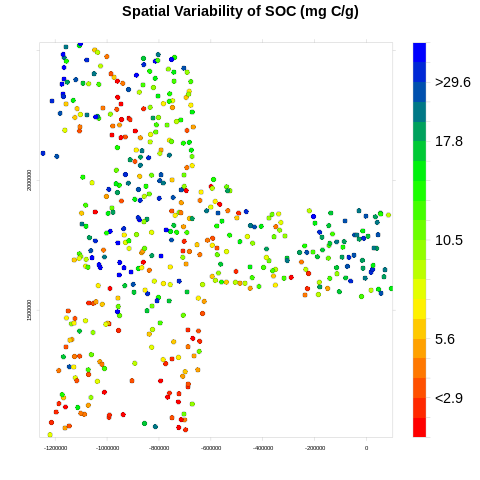

In [158]:
%%R
# Create a color palette
rgb.palette.col <- colorRampPalette(c("red","yellow", "green", "blue"),space = "rgb")

# Crate a Figure
soc<-levelplot(SOC~x+y, mf,cex=0.8,
              aspect = "iso",
              main= "Spatial Variability of SOC (mg C/g)",
              xlab="", ylab="",
              scales=list(y=list(draw=T,cex=0.5,rot=90, tck= 0.5),x=list(draw=T, cex=0.5,tck= 0.6)),
              par.settings=list(axis.line=list(col="grey",lwd=0.5)),
              col.regions=rgb.palette.col (20),at=at,
              colorkey=list(space="right",width=1.5,at=1:21,labels=list(cex=1.2,at=1:21,
              labels=c("","","<2.9", "","","5.6","","","","","10.5","","","","","17.8", "","",">29.6","",""))),
              panel = function(...) {
              panel.levelplot.points(...)
              #sp.polygons(state,lty=1,lwd=0.5,col="grey30")
              },)
soc

## Data split

The data set (n = 471) will be randomly split into 368 (80%) calibration data, which will be used for model development and 101 (20%) validation data which will used for evaluating the prediction models. For data splitting, we will use Stratified Random Sampling algorithms.

In [162]:
%%R

mf$NLCD<-as.factor(mf$NLCD)
mf$FRG<-as.factor(mf$FRG)

tr_prop = 0.80
# training data
train = ddply(mf, .(NLCD,FRG),function(., seed) { set.seed(seed); .[sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)
# Validation data (20% of data)
test = ddply(mf,  .(NLCD,FRG),
            function(., seed) { set.seed(seed); .[-sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)

write.csv(train, "/content/drive/MyDrive/Data/Spatial_Interpolatiom/train_data.csv", row.names=F)
write.csv(test, "/content/drive/MyDrive/Data/Spatial_Interpolatiom/test_data.csv", row.names=F)

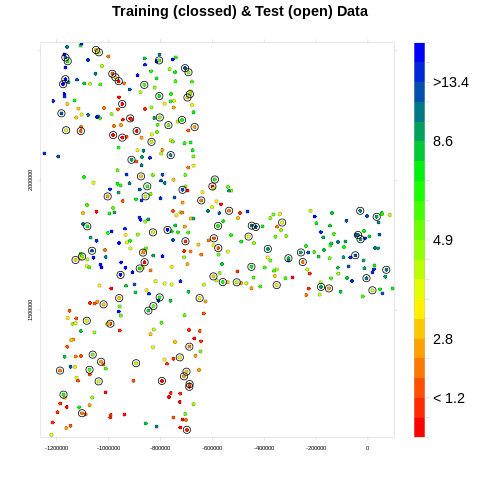

In [163]:
%%R

at = classIntervals(mf$SOC, n = 20, style = "quantile")$brks
round(quantile(mf$SOC, probs=seq(0,1, by=0.05)),1)

coordinates(test)<-~x+y
rgb.palette.col <- colorRampPalette(c("red","yellow", "green", "blue"),space = "rgb")

levelplot(SOC~x+y, mf,cex=0.6,
              aspect = "iso",main= "Training (clossed) & Test (open) Data",
              xlab="", ylab="",
              scales=list(y=list(draw=T,cex=0.5,rot=90, tck= 0.5),x=list(draw=T, cex=0.5,tck= 0.6)),
              par.settings=list(axis.line=list(col="grey",lwd=0.5)),
              col.regions=rgb.palette.col (20),at=at,
              colorkey=list(space="right",width=1.2,at=1:21,labels=list(cex=1.2,at=1:21,
              labels=c("","","< 1.2","" ,"","2.8","","","","","4.9","","","","","8.6","","",">13.4","",""))),
              panel = function(...) {
              panel.levelplot.points(...)
              sp.points(test, col="black", cex=1.2,pch=21)
              #sp.polygons(bound,lty=1,lwd=0.5,col="grey30")
              },)